<a href="https://colab.research.google.com/github/git-NatHat/000_First/blob/main/Mnist_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

In [56]:
# GPUを利用した計算を実行するかどうか。GPUを利用する場合、処理が変わるため、
# 条件分岐させている
# True: Use CuPy (Use GPU)
# False:Not use CuPy (Not use GPU)

use_cupy = True

In [2]:
# MnistデータをgoogleからDL
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
with np.load(path) as data:
  train_examples = data['x_train']
  train_labels = data['y_train']
  test_examples = data['x_test']
  test_labels = data['y_test']

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# このコードは現在未使用
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [4]:
#28×28の784画素の60000個の学習用文字画像セット
print(train_examples.shape) #shape属性でデータのサイズを表示

(60000, 28, 28)


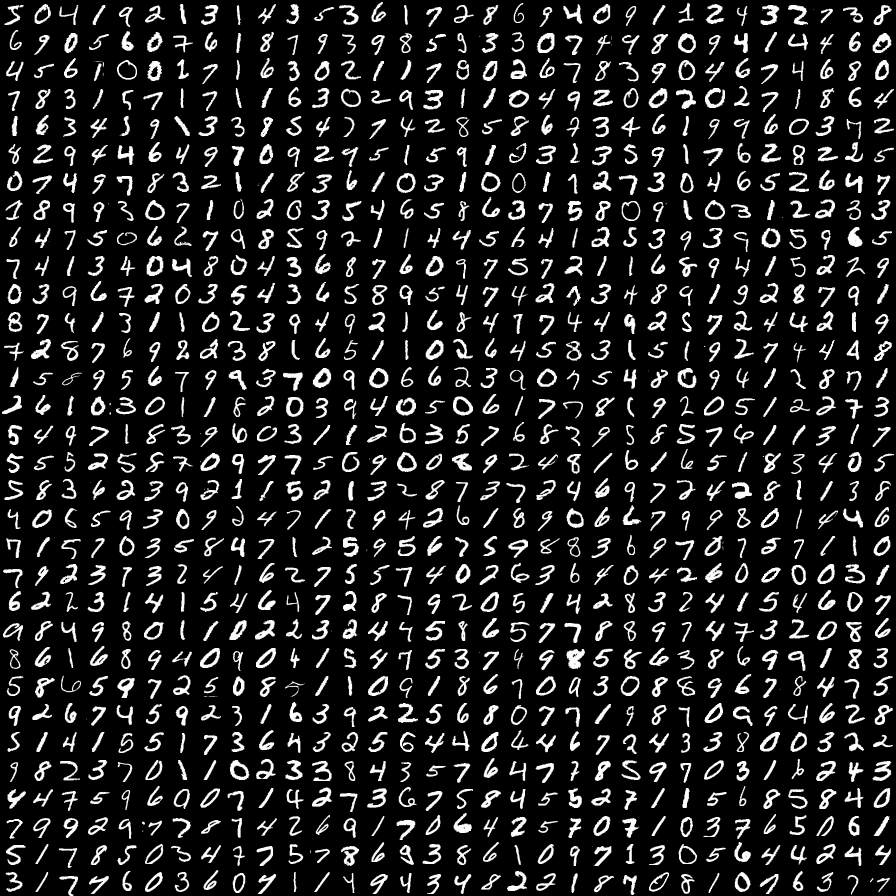

In [54]:
# MNISTに含まれるデータのイメージを縦横に並べて一括で表示

from PIL import Image
from IPython.display import display

# MNIST一文字の幅
chr_w = 28
# MNIST一文字の高さ
chr_h = 28
# 表示する文字数（縦方向、横方向共通）
num = 64

# 文字画像表示
def ConvertToImg(img):
    return Image.fromarray(np.uint8(img))

# MNISTの文字をPILで１枚の画像に描画する
canvas = Image.new('RGB', (int(chr_w * num/2), int(chr_h * num/2)), (255, 255, 255))

i = 0
for y in range( int(num/2) ):
    for x in range( int(num/2) ):
        chrImg = ConvertToImg(train_examples[i].reshape(chr_w, chr_h))
        canvas.paste(chrImg, (chr_w*x, chr_h*y))
        i = i + 1

display(canvas)

In [37]:
# ディープラーニングで共通的に利用する一般的な関数の定義

import numpy as np
import cupy as cp

def identity_function(x):
    return x

def step_function(x):
    if use_cupy:
      return cp.array(x > 0, dtype=cp.int)
    else:
      return np.array(x > 0, dtype=np.int)

def sigmoid(x):
    if use_cupy:
        # GPU利用時
        return 1 / (1 + cp.exp(-x))    
    else:
        # CPU利用時
        return 1 / (1 + np.exp(-x))    

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    
def relu(x):
    if use_cupy:
        return cp.maximum(0, x)
    else:
        return np.maximum(0, x)

def relu_grad(x):
    if use_cupy:
        grad = cp.zeros_like(x)
    else:
        grad = np.zeros_like(x)
    grad[x>=0] = 1
    return grad
    
def softmax(x):
    if use_cupy:
        # GPU利用時
        x = x - cp.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
        return cp.exp(x) / cp.sum(cp.exp(x), axis=-1, keepdims=True)
    else:
        # CPU利用時
        x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
        return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def sum_squared_error(y, t):
    if use_cupy:
        return 0.5 * cp.sum((y-t)**2)
    else:
        return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [38]:
# 数値的に微分を行う場合の処理。解析的に微分する場合は利用しない。
import numpy as np

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [41]:
# 2層のニューラルネットワーク
# 入力層の要素数、隠れ層の要素、出力層の要素数を指定
# 重みの初期値は0.01をデフォルトとし、引数で指定可能
import sys, os
import numpy as np
import cupy as cp

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        if use_cupy:
            # GPU利用時
            self.params['W1'] = weight_init_std * cp.random.randn(input_size, hidden_size)
            self.params['b1'] = cp.zeros(hidden_size)
            self.params['W2'] = weight_init_std * cp.random.randn(hidden_size, output_size)
            self.params['b2'] = cp.zeros(output_size)
        else:
            # CPU利用時
            self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
            self.params['b1'] = np.zeros(hidden_size)
            self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
            self.params['b2'] = np.zeros(output_size)


    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        if use_cupy:
            # GPU利用時   
            a1 = cp.dot(x, W1) + b1
            z1 = sigmoid(a1)
            a2 = cp.dot(z1, W2) + b2
            y = softmax(a2)
        else:
            # CPU利用時   
            a1 = np.dot(x, W1) + b1
            z1 = sigmoid(a1)
            a2 = np.dot(z1, W2) + b2
            y = softmax(a2)

        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        if use_cupy:
            # GPU利用時
            y = self.predict(x)
            y = cp.argmax(y, axis=1)
            t = cp.argmax(t, axis=1)
            accuracy = cp.sum(y == t) / float(x.shape[0])
        else:
            # CPU利用時
            y = self.predict(x)
            y = np.argmax(y, axis=1)
            t = np.argmax(t, axis=1)
            accuracy = np.sum(y == t) / float(x.shape[0])

        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        # 順方向伝播
        # 入力層Xと１層目の重みW1の積にバイアスを加える
        # 活性化関数としてシグモイド関数を適用
        # 2層目Z1と2層目の重みW1の積にバイアスを加える
        # 出力層の活性化関数ソフトマックス関数

        if use_cupy:
            # GPU利用時
            a1 = cp.dot(x, W1) + b1
            z1 = sigmoid(a1)
            a2 = cp.dot(z1, W2) + b2
            y = softmax(a2)
        else:
            # CPU利用時
            a1 = np.dot(x, W1) + b1
            z1 = sigmoid(a1)
            a2 = np.dot(z1, W2) + b2
            y = softmax(a2)

        # backward
        # 逆伝播

        if use_cupy:
            # GPU利用時
            dy = (y - t) / batch_num
            grads['W2'] = cp.dot(z1.T, dy)
            grads['b2'] = cp.sum(dy, axis=0)
            
            dz1 = cp.dot(dy, W2.T)
            da1 = sigmoid_grad(a1) * dz1
            grads['W1'] = cp.dot(x.T, da1)
            grads['b1'] = cp.sum(da1, axis=0)
        else:
            # CPU利用時
            dy = (y - t) / batch_num
            grads['W2'] = np.dot(z1.T, dy)
            grads['b2'] = np.sum(dy, axis=0)
            
            dz1 = np.dot(dy, W2.T)
            da1 = sigmoid_grad(a1) * dz1
            grads['W1'] = np.dot(x.T, da1)
            grads['b1'] = np.sum(da1, axis=0)

        return grads

train acc, test acc | 0.13813333333333333, 0.1331
train acc, test acc | 0.926, 0.9258
train acc, test acc | 0.9352166666666667, 0.9353
train acc, test acc | 0.9242666666666667, 0.9249
train acc, test acc | 0.9384333333333333, 0.9385
train acc, test acc | 0.9333, 0.9322
train acc, test acc | 0.9374166666666667, 0.9371
train acc, test acc | 0.9403166666666667, 0.939
train acc, test acc | 0.9407333333333333, 0.9403
train acc, test acc | 0.9462, 0.9449
train acc, test acc | 0.9383666666666667, 0.9395
train acc, test acc | 0.9351, 0.9328
train acc, test acc | 0.9455333333333333, 0.9458
train acc, test acc | 0.9482666666666667, 0.9474
train acc, test acc | 0.9449166666666666, 0.9426
train acc, test acc | 0.9440666666666667, 0.9401
train acc, test acc | 0.9401, 0.9375
32.09578 sec


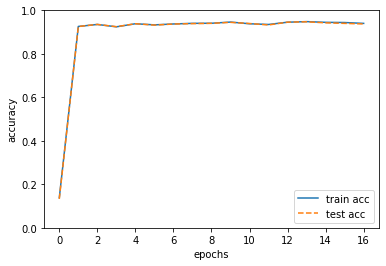

In [57]:
# 機械学習の実行（ディープラーニング）
# 

import sys, os
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time

# 処理時間計測スタート
time_start = time.time()

network = TwoLayerNet(input_size=784, hidden_size=1000, output_size=10)

# データの形式が異なるため、変換
if use_cupy:
# GPU利用時
    x_train = train_examples.reshape(60000,784)
    t_train = cp.identity(10)[train_labels]
    x_test = test_examples.reshape(10000,784)
    t_test = cp.identity(10)[test_labels]
    x_train = cp.asarray(x_train)
    t_train = cp.asarray(t_train)
    x_test = cp.asarray(x_test)
    t_test = cp.asarray(t_test)
else:
    # CPU利用時
    x_train = train_examples.reshape(60000,784)
    t_train = np.identity(10)[train_labels]
    x_test = test_examples.reshape(10000,784)
    t_test = np.identity(10)[test_labels]


iters_num = 10000  # 繰り返しの回数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)

    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch) # 数値微分
    grad = network.gradient(x_batch, t_batch) # 解析微分
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 処理時間計測エンド
time_end = time.time()

# 処理時間計算・出力
elapsed_time = time_end - time_start
print('{:.5f} sec'.format(elapsed_time))

# グラフの描画
markers = {'train': 'o', 'test': 's'}

# GPU使用時
if use_cupy:
    train_acc_list = cp.asnumpy(train_acc_list)
    test_acc_list = cp.asnumpy(test_acc_list)

x = np.arange(len(train_acc_list))

plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [58]:
# テストデータでの認識結果を表示
# 認識誤りがあるものは、各分類要素ごとの確率を合わせて出力

for i in np.arange(0,200):
  chrImg = ConvertToImg(test_examples[i].reshape(chr_w, chr_h))
  display(chrImg)
  npt = network.predict(x_test[i])
  if npt.argmax() == test_labels[i]:
    print(f'Predict:{npt.argmax()},Anser:{test_labels[i]}')
  else:
    print(f'Predict:{npt.argmax()},Anser:{test_labels[i]}-->NG',npt)

Predict:7,Anser:7


Predict:2,Anser:2


Predict:1,Anser:1


Predict:0,Anser:0


Predict:4,Anser:4


Predict:1,Anser:1


Predict:4,Anser:4


Predict:9,Anser:9


Predict:6,Anser:5-->NG [2.05329018e-02 4.44465442e-04 3.80519408e-01 5.64671021e-05
 5.58419079e-03 6.22212942e-02 5.15295845e-01 4.62302660e-05
 4.43839179e-03 1.08608059e-02]


Predict:9,Anser:9


Predict:0,Anser:0


Predict:6,Anser:6


Predict:9,Anser:9


Predict:0,Anser:0


Predict:1,Anser:1


Predict:5,Anser:5


Predict:9,Anser:9


Predict:7,Anser:7


Predict:3,Anser:3


Predict:4,Anser:4


Predict:9,Anser:9


Predict:6,Anser:6


Predict:6,Anser:6


Predict:5,Anser:5


Predict:4,Anser:4


Predict:0,Anser:0


Predict:7,Anser:7


Predict:4,Anser:4


Predict:0,Anser:0


Predict:1,Anser:1


Predict:3,Anser:3


Predict:1,Anser:1


Predict:3,Anser:3


Predict:4,Anser:4


Predict:7,Anser:7


Predict:2,Anser:2


Predict:7,Anser:7


Predict:1,Anser:1


Predict:2,Anser:2


Predict:1,Anser:1


Predict:1,Anser:1


Predict:7,Anser:7


Predict:4,Anser:4


Predict:2,Anser:2


Predict:3,Anser:3


Predict:5,Anser:5


Predict:1,Anser:1


Predict:2,Anser:2


Predict:4,Anser:4


Predict:4,Anser:4


Predict:6,Anser:6


Predict:3,Anser:3


Predict:5,Anser:5


Predict:5,Anser:5


Predict:6,Anser:6


Predict:0,Anser:0


Predict:4,Anser:4


Predict:1,Anser:1


Predict:9,Anser:9


Predict:5,Anser:5


Predict:7,Anser:7


Predict:8,Anser:8


Predict:9,Anser:9


Predict:3,Anser:3


Predict:7,Anser:7


Predict:4,Anser:4


Predict:6,Anser:6


Predict:4,Anser:4


Predict:3,Anser:3


Predict:0,Anser:0


Predict:7,Anser:7


Predict:0,Anser:0


Predict:2,Anser:2


Predict:9,Anser:9


Predict:1,Anser:1


Predict:7,Anser:7


Predict:3,Anser:3


Predict:7,Anser:2-->NG [7.62917348e-05 5.21487185e-04 4.60472117e-01 7.42823611e-04
 1.58184335e-06 5.82659767e-04 3.12354345e-04 5.33414640e-01
 3.52616784e-03 3.49876971e-04]


Predict:9,Anser:9


Predict:7,Anser:7


Predict:7,Anser:7


Predict:6,Anser:6


Predict:2,Anser:2


Predict:7,Anser:7


Predict:8,Anser:8


Predict:4,Anser:4


Predict:7,Anser:7


Predict:3,Anser:3


Predict:6,Anser:6


Predict:1,Anser:1


Predict:3,Anser:3


Predict:6,Anser:6


Predict:9,Anser:9


Predict:3,Anser:3


Predict:1,Anser:1


Predict:4,Anser:4


Predict:1,Anser:1


Predict:7,Anser:7


Predict:6,Anser:6


Predict:9,Anser:9


Predict:6,Anser:6


Predict:0,Anser:0


Predict:5,Anser:5


Predict:4,Anser:4


Predict:9,Anser:9


Predict:9,Anser:9


Predict:2,Anser:2


Predict:1,Anser:1


Predict:9,Anser:9


Predict:4,Anser:4


Predict:8,Anser:8


Predict:7,Anser:7


Predict:3,Anser:3


Predict:9,Anser:9


Predict:7,Anser:7


Predict:4,Anser:4


Predict:4,Anser:4


Predict:4,Anser:4


Predict:9,Anser:9


Predict:2,Anser:2


Predict:5,Anser:5


Predict:4,Anser:4


Predict:7,Anser:7


Predict:6,Anser:6


Predict:4,Anser:7-->NG [2.62016288e-05 1.41948140e-04 3.11850960e-06 3.39991151e-03
 3.88078963e-01 5.44963834e-03 9.91439754e-05 3.65609404e-01
 6.89529948e-03 2.30296372e-01]


Predict:9,Anser:9


Predict:0,Anser:0


Predict:5,Anser:5


Predict:8,Anser:8


Predict:5,Anser:5


Predict:6,Anser:6


Predict:6,Anser:6


Predict:5,Anser:5


Predict:7,Anser:7


Predict:8,Anser:8


Predict:1,Anser:1


Predict:0,Anser:0


Predict:1,Anser:1


Predict:6,Anser:6


Predict:4,Anser:4


Predict:6,Anser:6


Predict:7,Anser:7


Predict:3,Anser:3


Predict:1,Anser:1


Predict:7,Anser:7


Predict:1,Anser:1


Predict:8,Anser:8


Predict:2,Anser:2


Predict:0,Anser:0


Predict:9,Anser:2-->NG [4.46743395e-04 2.40748451e-03 1.85659756e-01 4.40468888e-02
 2.03612010e-02 3.07537644e-02 1.54079733e-03 2.25924271e-03
 1.63815742e-02 6.96142548e-01]


Predict:9,Anser:9


Predict:9,Anser:9


Predict:5,Anser:5


Predict:5,Anser:5


Predict:1,Anser:1


Predict:5,Anser:5


Predict:6,Anser:6


Predict:0,Anser:0


Predict:3,Anser:3


Predict:4,Anser:4


Predict:4,Anser:4


Predict:6,Anser:6


Predict:5,Anser:5


Predict:4,Anser:4


Predict:6,Anser:6


Predict:5,Anser:5


Predict:4,Anser:4


Predict:5,Anser:5


Predict:1,Anser:1


Predict:4,Anser:4


Predict:4,Anser:4


Predict:7,Anser:7


Predict:2,Anser:2


Predict:3,Anser:3


Predict:2,Anser:2


Predict:7,Anser:7


Predict:1,Anser:1


Predict:8,Anser:8


Predict:1,Anser:1


Predict:8,Anser:8


Predict:1,Anser:1


Predict:8,Anser:8


Predict:5,Anser:5


Predict:0,Anser:0


Predict:8,Anser:8


Predict:9,Anser:9


Predict:2,Anser:2


Predict:5,Anser:5


Predict:0,Anser:0


Predict:1,Anser:1


Predict:1,Anser:1


Predict:1,Anser:1


Predict:0,Anser:0


Predict:9,Anser:9


Predict:0,Anser:0


Predict:3,Anser:3


Predict:1,Anser:1


Predict:6,Anser:6


Predict:4,Anser:4


Predict:2,Anser:2
